## Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import STAHD
os.environ['R_HOME'] = "/usr/lib/R/"
os.environ['R_USER'] = "~/.conda/envs/STAHD/lib/python3.8/site-packages/rpy2"       
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
from STAHD.ST_utils import set_seed
set_seed(2024)

## Load Data

In [2]:
import scanpy as sc
import h5py
data_file = '/home/dwang/code/STAHI-minibatch/Visium_human-tonsil-fresh-frozen-if /square_008um/filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(data_file)
print(adata)

AnnData object with n_obs × n_vars = 679294 × 18085
    var: 'gene_ids', 'feature_types', 'genome'


In [3]:
coordinates = []
for name in adata.obs_names:
    parts = name.split('_')
    x_coord = int(parts[2])  
    y_coord = int(parts[3].split('-')[0])  
    coordinates.append([x_coord, y_coord])
coordinates_array = np.array(coordinates)
adata.obsm['spatial'] = coordinates_array
adata

AnnData object with n_obs × n_vars = 679294 × 18085
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

------Calculating spatial graph...
The graph contains 29764286 edges, 679294 cells.
43.8165 neighbors per cell on average.


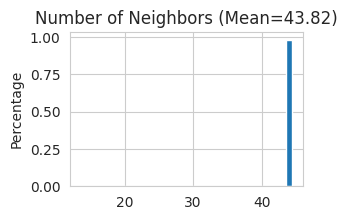

In [4]:
# Constructing the spatial network
STAHD.Cal_Spatial_Net(adata, rad_cutoff=4)  # the spatial network are saved in adata.uns[‘adj’]
STAHD.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
adata.uns['edgeList'] = np.nonzero(adata.uns['adj'])

# Normalization
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, adata.var['highly_variable']]

## Running STAHD

In [5]:
strna = STAHD.train_STAHD(adata, hidden_dims=[50, 30], verbose=True, batch_size=4096, device=used_device)

STAHD(
  (conv1): GATConv(3000, 50, heads=1)
  (conv2): GATConv(50, 30, heads=1)
  (conv3): GATConv(30, 50, heads=1)
  (conv4): GATConv(50, 3000, heads=1)
)
Pretrain with STAHD...


100%|██████████| 1000/1000 [1:21:53<00:00,  4.91s/it]


## Clustering

In [6]:
STAHD.mclust_R(strna, num_cluster=7, used_obsm='STAHD')

fitting ...

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%




AnnData object with n_obs × n_vars = 679294 × 3000
    obs: 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'adj', 'edgeList', 'hvg', 'log1p'
    obsm: 'spatial', 'STAHD'
    layers: 'STAHD_ReX'

## Visualization

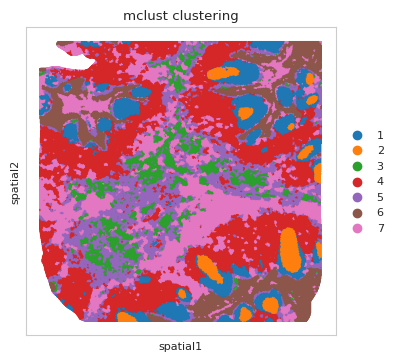

In [14]:
sc.pl.embedding(strna, basis="spatial",color='mclust', title='mclust clustering', s=2)

In [15]:
strna.obs['mclust'] = strna.obs['mclust'].astype(str)

cluster_annotation = {
    '1': 'B cell zone (naive B cells)',
    '2': 'Germinal center (GC B cells / FDC)',
    '3': 'Subepithelial fibroblast zone',
    '4': 'T cell zone (paracortex)',
    '5': 'Plasma cell-rich area',
    '6': 'Crypt epithelium (inflammatory epithelium)',
    '7': 'Inflamed (Neutrophil-rich crypt epithelium)',
}
cluster_annotation1 = {i: cluster_annotation[i].split(' (')[0] for i in cluster_annotation}
strna.obs["cluster_annotation"] = strna.obs["mclust"].map(cluster_annotation)
strna.obs["cluster_annotation1"] = strna.obs["mclust"].map(cluster_annotation1)

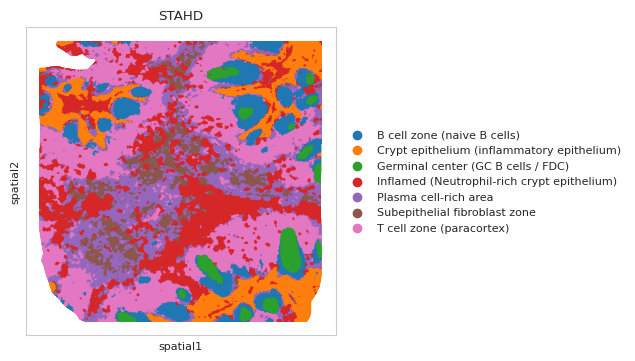

In [20]:
import matplotlib.pyplot as plt
import scanpy as sc
spot_size = 2
title_size = 15
fig, ax = plt.subplots()
sc.pl.embedding(strna, basis="spatial",color=['cluster_annotation'], title=['STAHD'], s=2,ax=ax)
legend = ax.get_legend()
if legend is not None:
    legend.set_title("STAHD annotations", prop={ 'size': 15})
    for text in legend.get_texts():
        text.set_fontsize(10)  
plt.show()